In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Imports 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the path to your image folder
image_folder = '/kaggle/input/gananime-lite/out2'

# Define image dimensions
img_height = 64
img_width = 64
channels = 3

In [4]:
# Custom dataset class
class AnimeDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [5]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Changing the pixel values in between -1 to 1 
])

In [6]:
# Create dataset and dataloader
dataset = AnimeDataset(image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

In [7]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 8*8*256),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [8]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

In [9]:
# Initialize networks and optimizers
latent_dim = 100
generator = Generator(latent_dim)
discriminator = Discriminator()

In [10]:
# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

In [11]:
# Setting the optimizer, learning rate and betas parameter
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss().to(device)

In [12]:
# Training loop
num_epochs = 50
sample_interval = 10

for epoch in range(num_epochs):
    for i, real_images in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Ground truths
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Generator
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)
        g_loss = adversarial_loss(discriminator(fake_images), real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Train Discriminator
        d_optimizer.zero_grad()
        real_loss = adversarial_loss(discriminator(real_images), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}")

    if (epoch + 1) % sample_interval == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim).to(device)
            fake_images = generator(z).cpu()
            fake_images = (fake_images + 1) / 2  # Denormalize
            
            fig, axs = plt.subplots(4, 4, figsize=(10, 10))
            for i in range(4):
                for j in range(4):
                    axs[i, j].imshow(fake_images[i*4 + j].permute(1, 2, 0))
                    axs[i, j].axis('off')
            plt.tight_layout()
            plt.savefig(f'gan_generated_image_epoch_{epoch+1}.png')
            plt.close()

# Save the trained model
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

Epoch [1/50] D_loss: 0.0347 G_loss: 3.3868
Epoch [2/50] D_loss: 0.0282 G_loss: 4.1542
Epoch [3/50] D_loss: 0.0510 G_loss: 4.2604
Epoch [4/50] D_loss: 0.0252 G_loss: 4.5139
Epoch [5/50] D_loss: 0.0623 G_loss: 4.2481
Epoch [6/50] D_loss: 0.2438 G_loss: 1.4413
Epoch [7/50] D_loss: 0.0896 G_loss: 2.6816
Epoch [8/50] D_loss: 0.0913 G_loss: 5.1461
Epoch [9/50] D_loss: 0.1188 G_loss: 3.9160
Epoch [10/50] D_loss: 0.0560 G_loss: 6.4980
Epoch [11/50] D_loss: 0.0765 G_loss: 3.2684
Epoch [12/50] D_loss: 0.0762 G_loss: 4.3258
Epoch [13/50] D_loss: 0.0842 G_loss: 2.8203
Epoch [14/50] D_loss: 0.0461 G_loss: 3.9312
Epoch [15/50] D_loss: 0.0946 G_loss: 4.1487
Epoch [16/50] D_loss: 0.0577 G_loss: 3.3452
Epoch [17/50] D_loss: 0.0649 G_loss: 3.5961
Epoch [18/50] D_loss: 0.2455 G_loss: 1.5186
Epoch [19/50] D_loss: 0.3335 G_loss: 1.7177
Epoch [20/50] D_loss: 0.0581 G_loss: 3.2609
Epoch [21/50] D_loss: 0.1062 G_loss: 3.8801
Epoch [22/50] D_loss: 0.0612 G_loss: 2.8649
Epoch [23/50] D_loss: 0.0320 G_loss: 3.93

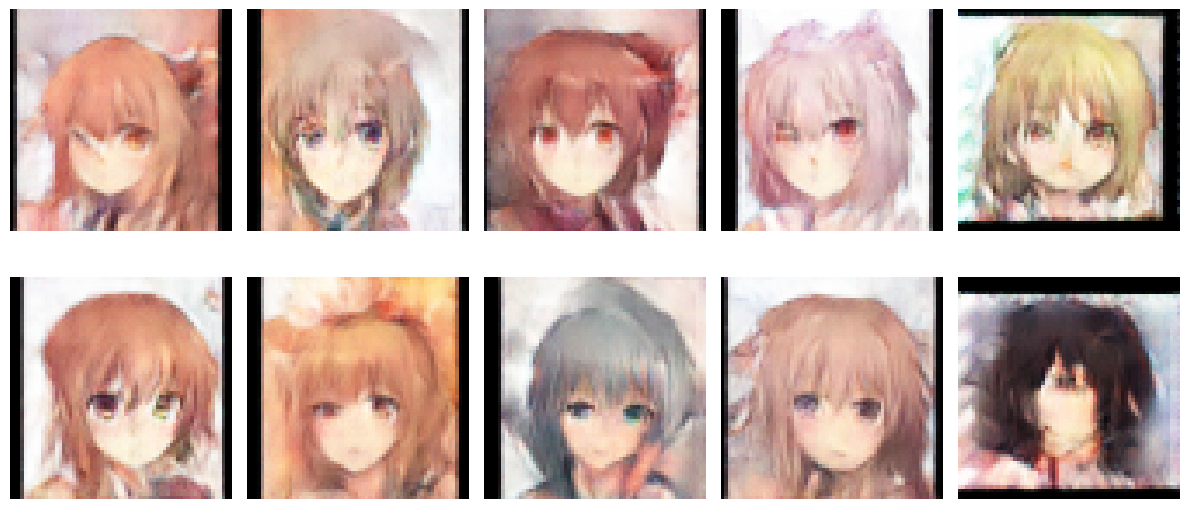

In [13]:
# Generate and view 10 new images after the training
with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)  # Generate 10 images
    fake_images = generator(z).cpu()
    fake_images = (fake_images + 1) / 2  # Denormalize
    
    fig, axs = plt.subplots(2, 5, figsize=(12, 6))  # 2x5 grid for 10 images
    for i in range(2):
        for j in range(5):
            axs[i, j].imshow(fake_images[i*5 + j].permute(1, 2, 0))
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()  # Display the images in the notebook/output
    plt.close()
